In [1]:
__author__ = "Pujun Bhatnagar"
__version__ = "Stanford, Spring 2016"

In [2]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt


from __future__ import division, print_function, absolute_import
import json
from pprint import pprint
import pickle
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences
from tflearn.datasets import imdb
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import math
import csv
import numpy as np
import openpyxl as px
import numpy as np

import os
import sys
import csv
import random
import itertools
from operator import itemgetter
from collections import defaultdict
import numpy as np
import scipy
import scipy.spatial.distance
from numpy.linalg import svd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import utils


In [3]:
# load the original model to make sure that the tensorflow model is loaded properly
import pickle
lstm_vocab = pickle.load(open('/home/pujun/Desktop/StanfordClasses/icgauge/data/lstm_vocab', 'rb'))
lstm_vocab_list = lstm_vocab.items()
lstm_vocab_list = sorted(lstm_vocab_list, key=lambda tup: tup[1])
len(lstm_vocab_list)


24318

In [4]:
# initialize the parts of the tensorflow model to reload all the weights
num_words_in_longest_sentence = 512
word_count = len(lstm_vocab_list) + 1
layer_input = tflearn.input_data([None, num_words_in_longest_sentence])
embedding = tflearn.embedding(layer_input, input_dim=word_count, output_dim=128)
lstm = tflearn.lstm(embedding, 128)
dropout = tflearn.dropout(lstm, 0.5)
softmax = tflearn.fully_connected(dropout, 2, activation='softmax')
net = tflearn.regression(softmax, optimizer='adam',
                       loss='categorical_crossentropy')

In [5]:
# define the model
model = tflearn.DNN(softmax)

In [6]:
model.load("/home/pujun/Desktop/StanfordClasses/icgauge/data/LSTM_models/SNLI_SICK_custom_embedding/SNLI_SICK_custom_embedding")


In [7]:
embedding_var = tflearn.get_layer_variables_by_name('Embedding')[0]

In [8]:
type(embedding_var)

tensorflow.python.ops.variables.Variable

In [9]:
mat = model.get_weights(embedding_var)

In [10]:
# this matrix contains all the embedding representations
mat.shape

(24319, 128)

In [11]:
# let's load up the pickel that contains the top 1435 words --> (their assigned index, number of times they have occured)
lstm_vocab = pickle.load(open('/home/pujun/Desktop/StanfordClasses/icgauge/lstm/lstm_vocab_169.4890616', 'rb'))
lstm_vocab_list = lstm_vocab.items()
lstm_vocab_list = sorted(lstm_vocab_list, key=lambda tup: tup[1][0])
word_count = len(lstm_vocab_list)


In [12]:
# since now we only want to consider the first 1435 words, we make a np.array in which we will dump the embeddings
filtered_mat = np.random.rand(word_count, 128)
count = 0
for _,i in lstm_vocab.items():
    filtered_mat[count] = mat[i[0]]
    count += 1

In [13]:
# since we want to color the words based on the frequency of of their occurance

# make a list containing the frequencies of these words
frequency_val = [val[1] for key, val in lstm_vocab_list]

# figure out the maximum and the minimum val
maximum_frequency = np.max(frequency_val) + 0.1
minimum_frequency = np.min(frequency_val) 

print("Max frequency: %d and Min frequency: %d" % (maximum_frequency, minimum_frequency))

Max frequency: 505734 and Min frequency: 170


In [14]:
# Could not think of a better coloring technique so decided to go with VIBGYOR
color_pallette = ['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red']

# since we want to split the frequency into 7 equal buckets, we calculate the dividor that we will need to divide by to get those color codings
dividor = (maximum_frequency - minimum_frequency) / (len(color_pallette))

# figure out the actual colors
colors = [color_pallette[int((i - minimum_frequency)/dividor)] for i in frequency_val]

In [15]:
# check for the number of components. If the matrix representation is high, then just do the lower one
n_components = 50 if filtered_mat.shape[1] >= 50 else filtered_mat.shape[1]

In [16]:
dimreduce = PCA(n_components=n_components)

In [17]:
filtered_mat = dimreduce.fit_transform(filtered_mat)

In [18]:
filtered_mat.shape

(1435, 50)

In [19]:
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True) 

In [20]:
tsnemat = tsne.fit_transform(filtered_mat)

In [21]:
# tsnemat = pickle.load(open('/home/pujun/Desktop/StanfordClasses/icgauge/data/tsnemat.p', 'rb'))
print(tsnemat.shape)

(1435, 2)


In [22]:
rownames = lstm_vocab_list
rownames = [w for w, v in lstm_vocab_list]

In [23]:
indices = list(range(len(rownames)))
print(len(indices))

1435


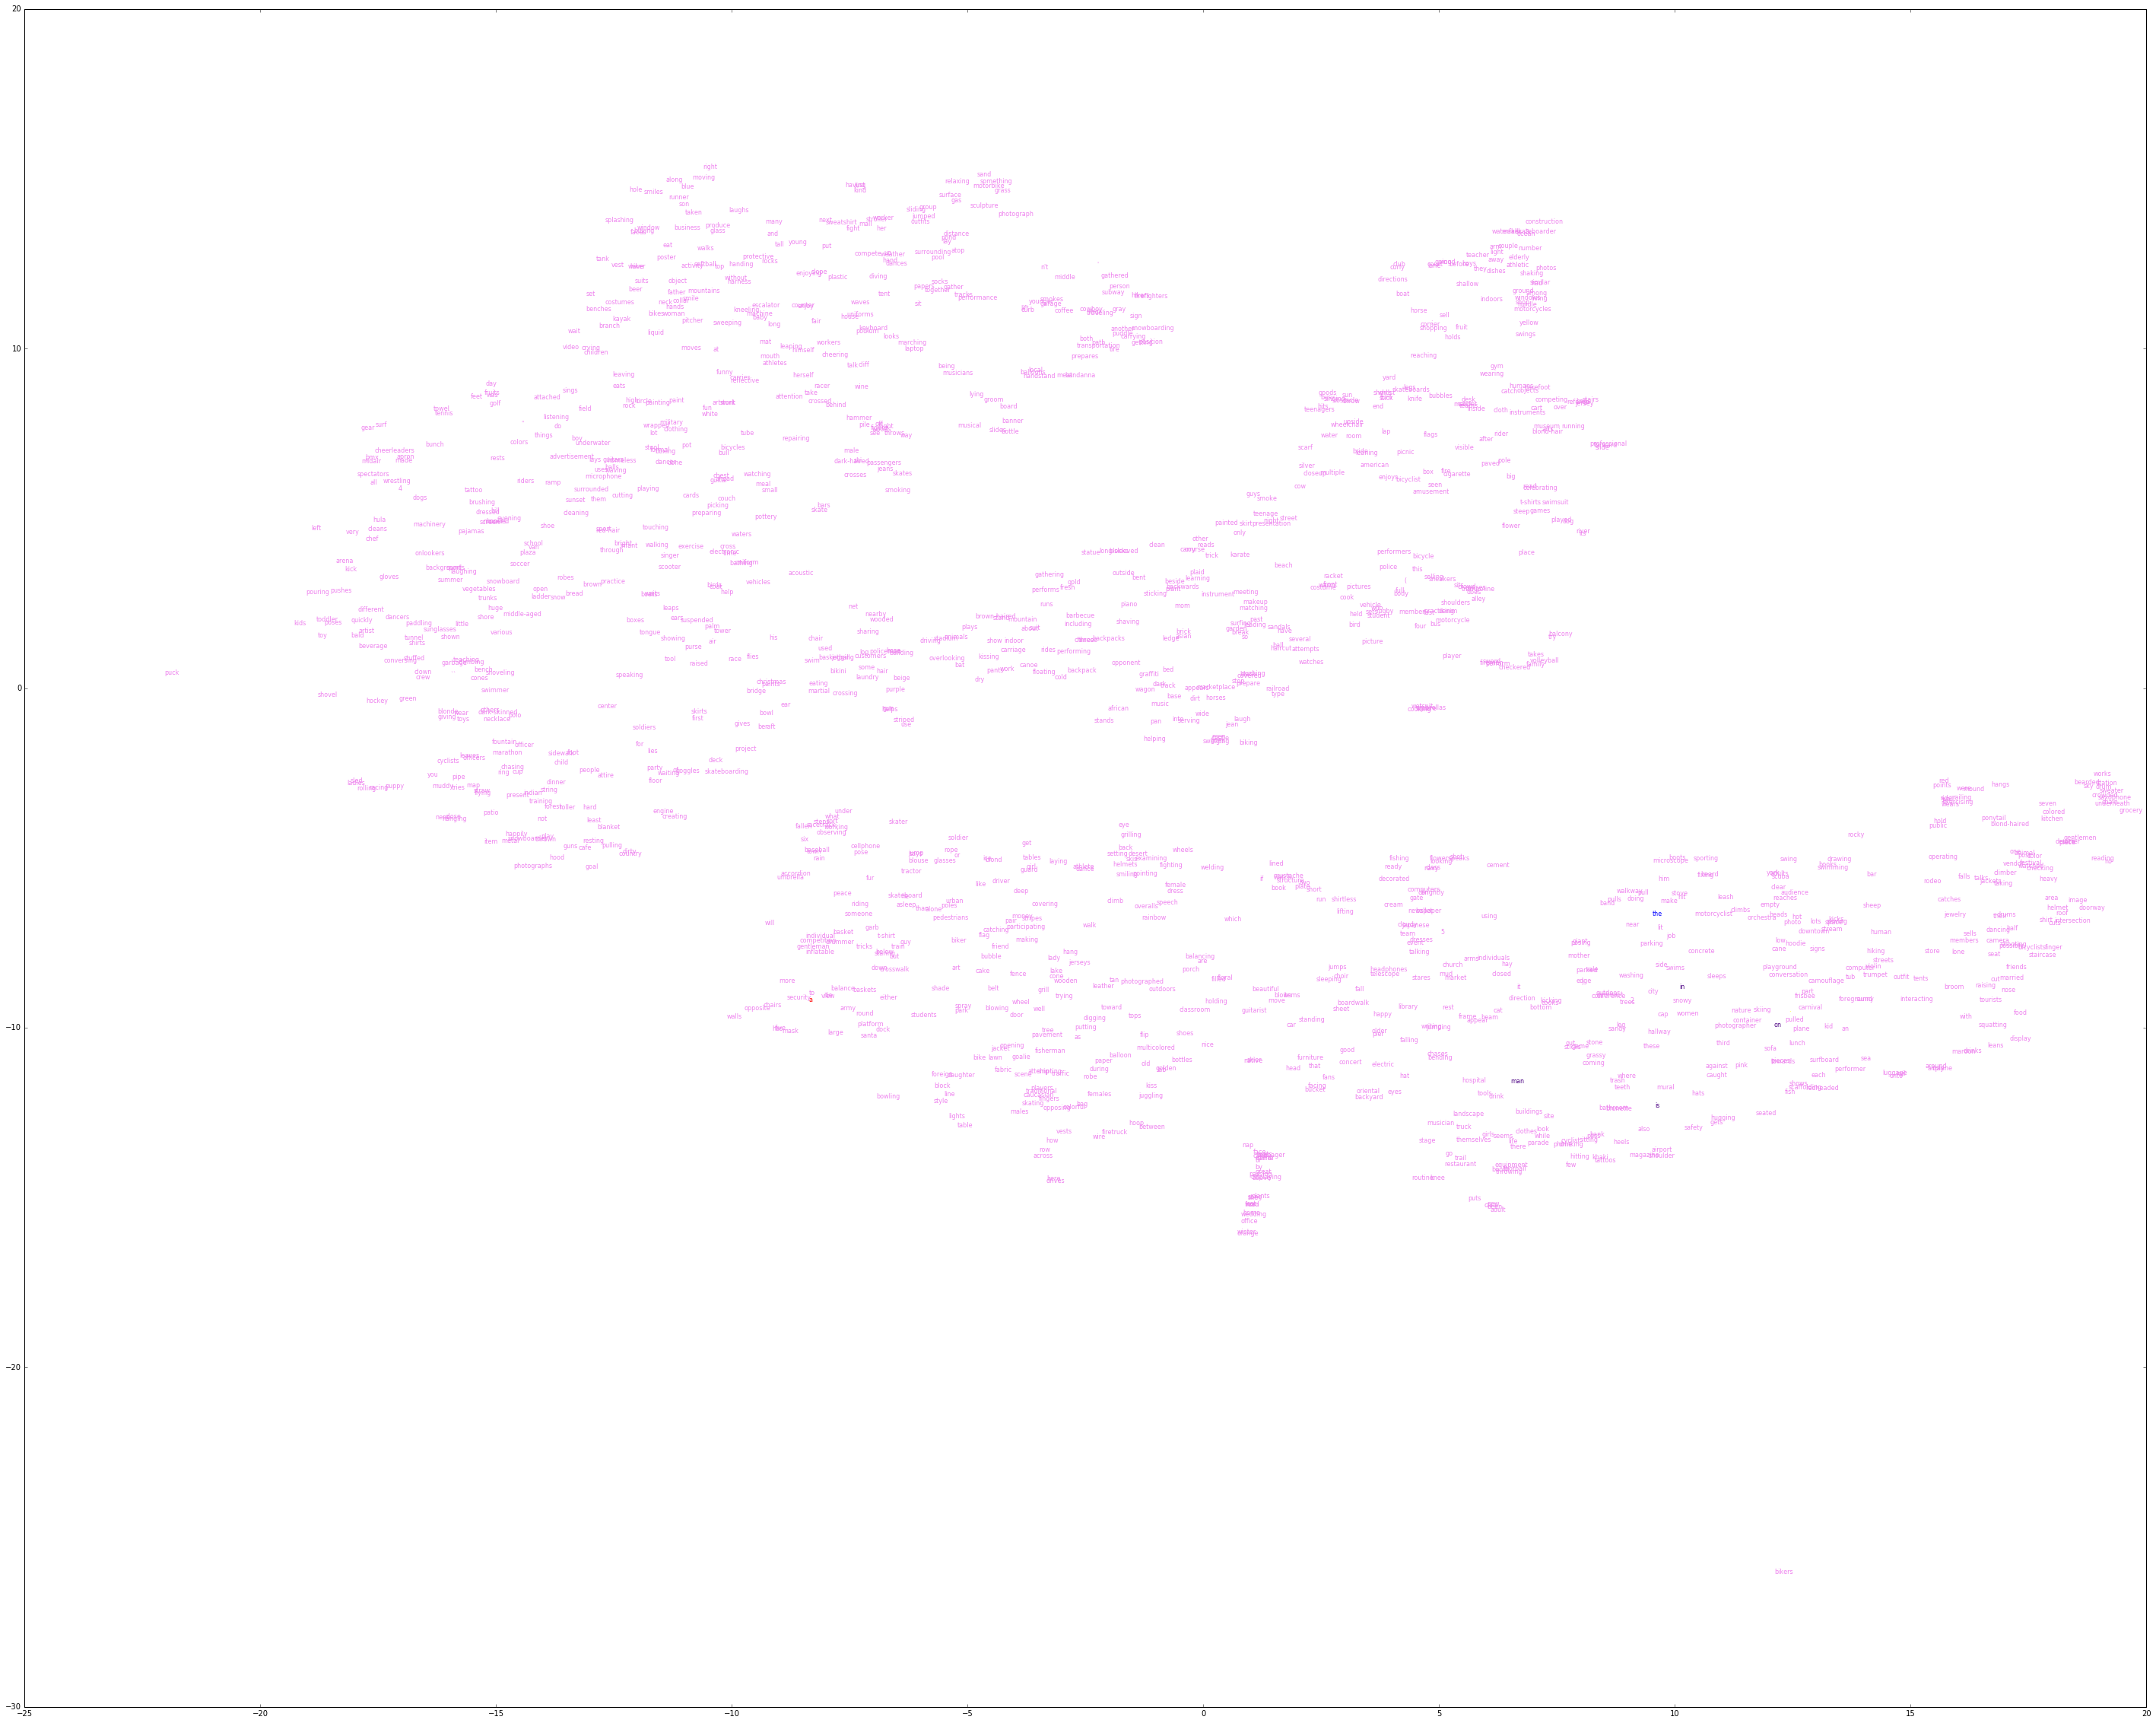

In [24]:
vocab = np.array(rownames)[indices]
xvals = tsnemat[indices, 0] 
yvals = tsnemat[indices, 1]
# Plotting:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(40)
fig.set_figwidth(50)
ax.plot(xvals, yvals, marker='', linestyle='')
# Text labels:
for word, x, y, color in zip(vocab, xvals, yvals, colors):
    ax.annotate(word, (x, y), fontsize=8, color=color)

plt.show()